In [78]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.compute as pc
import pyarrow.dataset as ds
import math
import re
import ahocorasick

## Analysis of Canonical Peptides

In [44]:
parq_file = "../PXD010154-pangenome-canonical-0.01.parquet"
table = pq.read_table(parq_file)
df = table.to_pandas()

In [45]:
#shorten accessions to save memory
def get_source(accessions):
    accessions = accessions.split(',')

    for acc in accessions:
        if acc.startswith('DECOY_CONTAMINANT'):
            return 'DECOY_CONTAMINANT'
    for acc in accessions:
        if acc.startswith('CONTAMINANT'):
            return 'CONTAMINANT'
    
    for acc in accessions:
        if acc.startswith('DECOY_GRCh38'):
            return 'DECOY_GRCh38'
    
    for acc in accessions:
        if acc.startswith('DECOY_GCA'):
            return 'DECOY_GCA'

    for acc in accessions:
        if acc.startswith('GRCh38'):
            return 'GRCh38'
    
    for acc in accessions:
        if acc.startswith('GCA'):
            return 'GCA'
    
    return accessions


In [46]:
print('Number of PSMs in the file = ', len(df))

Number of PSMs in the file =  15590886


In [47]:
#Convert array values in the accession to list
def join_vals(x):
    return ','.join(x.astype(str).tolist())

In [48]:
df['protein_accessions'] = df['protein_accessions'].apply(join_vals)

In [ ]:
df['prot_source'] = df['protein_accessions'].apply(get_source)

In [49]:
df['prot_source'].value_counts()

prot_source
GRCh38               10378371
GCA                   4486553
CONTAMINANT            571594
DECOY_GCA               99782
DECOY_GRCh38            53403
DECOY_CONTAMINANT        1183
Name: count, dtype: int64

In [50]:
df.to_csv('can.tsv',sep='\t', index=False, columns=['sequence', 'protein_accessions', 'protein_global_qvalue', 'unique', 'retention_time', 'charge', 'peptidoform', 'posterior_error_probability', 'global_qvalue', 'is_decoy', 'reference_file_name', 'consensus_support', 'scan_number', 'mz_array', 'intensity_array', 'num_peaks', 'gene_accessions', 'gene_names'])

/var/folders/83/779t9dx51z137ypgyzhsj2nh0000gp/T/ipykernel_11091/2754138578.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gca['posterior_error_probability'],
/var/folders/83/779t9dx51z137ypgyzhsj2nh0000gp/T/ipykernel_11091/2754138578.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gr

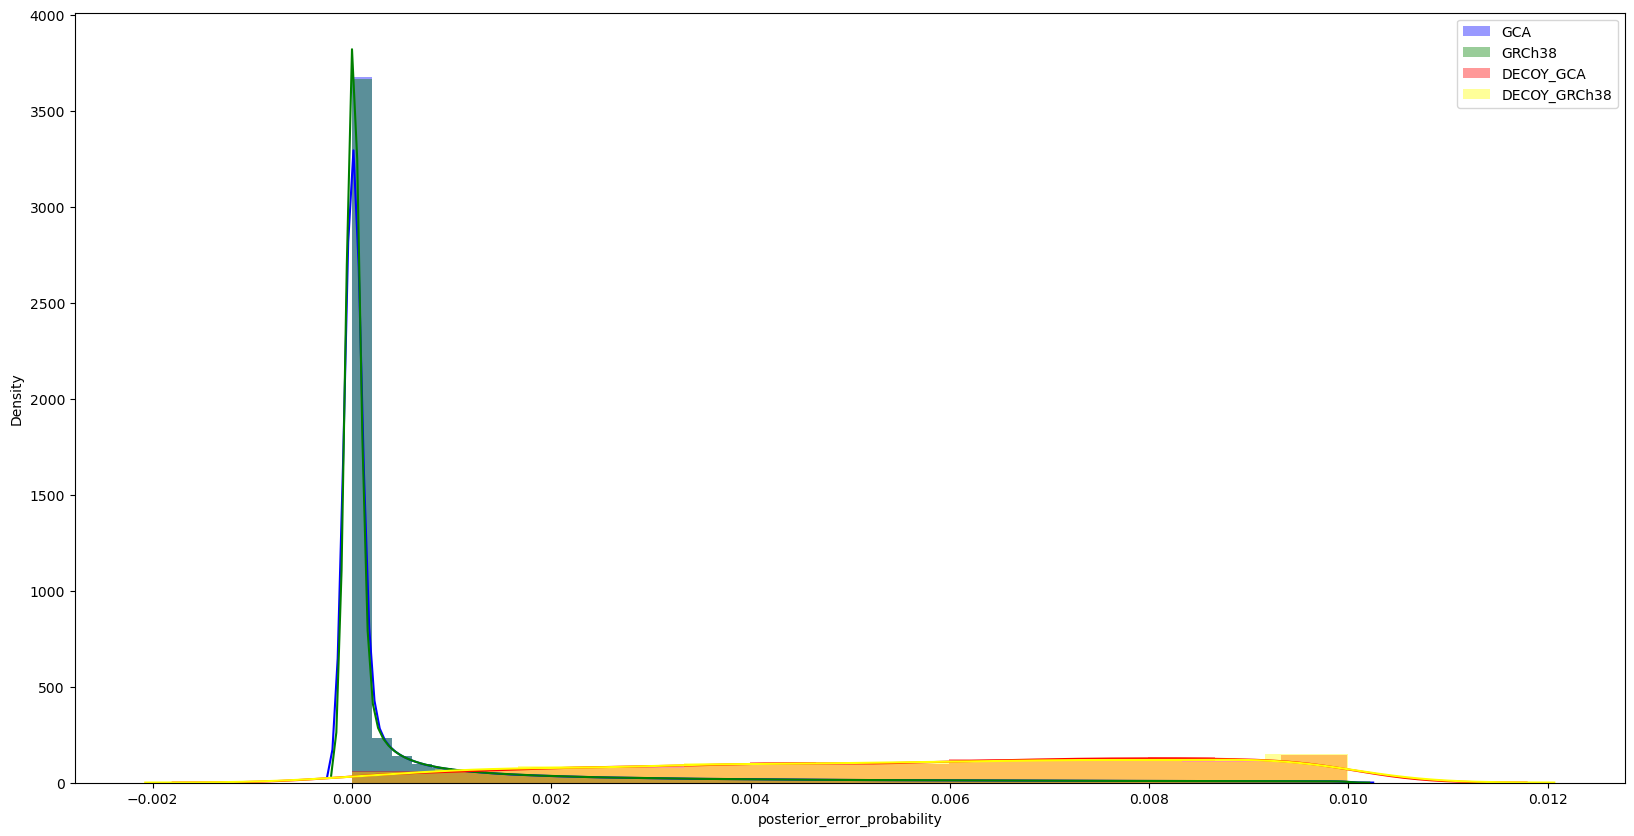

In [51]:
df2 = df[df['posterior_error_probability']<0.01]

gca = df2.loc[df2.prot_source.str.startswith("GCA")==True]
grch = df2.loc[df2.prot_source.str.startswith("GRCh38")==True]
decoy_grch = df2.loc[df2.prot_source.str.startswith("DECOY_GRCh38")==True]
decoy_gca = df2.loc[df2.prot_source.str.startswith("DECOY_GCA")==True]

#sns.df['posterior_error_probability']

plt.figure(figsize=(20, 10))
sns.distplot(gca['posterior_error_probability'], 
             hist=True, kde=True, label='GCA', color='blue')
sns.distplot(grch['posterior_error_probability'], 
             hist=True, kde=True, label='GRCh38', color='green')
sns.distplot(decoy_gca['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GCA', color='red')
sns.distplot(decoy_grch['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GRCh38', color='yellow')

plt.legend()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'GRCh38'),
  Text(1, 0, 'GCA'),
  Text(2, 0, 'CONTAMINANT'),
  Text(3, 0, 'DECOY_GRCh38'),
  Text(4, 0, 'DECOY_GCA'),
  Text(5, 0, 'DECOY_CONTAMINANT')])

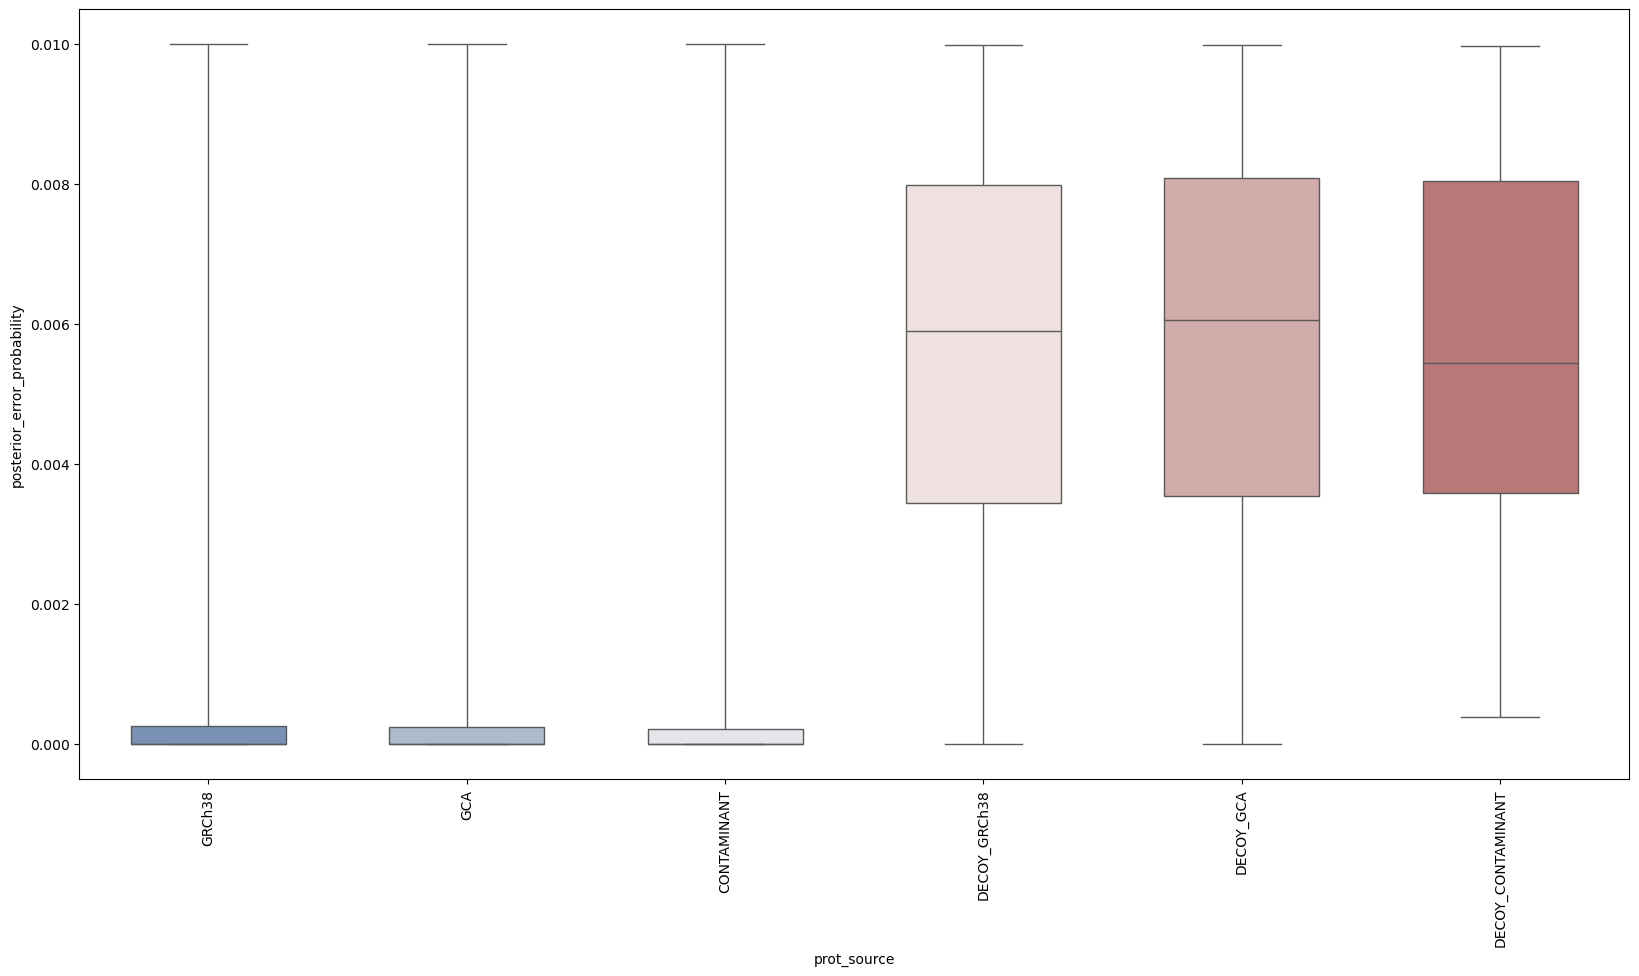

In [53]:
plt.figure(figsize=(20, 10))

sns.boxplot(
    df2, x="prot_source", y="posterior_error_probability", hue="prot_source",
    whis=[0, 100], width=.6, palette="vlag"
)
plt.xticks(rotation=90) 

In [54]:
df[df['posterior_error_probability']<0.01]['prot_source'].value_counts()

prot_source
GRCh38               8839516
GCA                  3755540
CONTAMINANT           483633
DECOY_GCA               2125
DECOY_GRCh38            1089
DECOY_CONTAMINANT         47
Name: count, dtype: int64

In [55]:
print('Number of unique peptide sequences from\n GCA: {}\n canonical: {}'.format(len(gca.sequence.unique()), len(grch.sequence.unique())))
print('union', len(set(grch.sequence).union(set(gca.sequence))))
print('intesect', len(set(grch.sequence).intersection(set(gca.sequence))))


Number of unique peptide sequences from
 GCA: 142681
 canonical: 179461
union 322142
intesect 0


In [58]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [59]:
gca_seqs = list(set([rep(x) for x in gca['sequence'].tolist()]))

In [60]:
len(gca_seqs)

142681

In [64]:
#get all canonical sequences from fasta
canonical_proteins_fasta = 'Homo_sapiens.GRCh38.pep.all.fa'
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))
print(len(allcan_seqs))

95816


In [65]:
#get non-canonical peptides that are found in canonical proteins
gca_found_peps = []
auto = ahocorasick.Automaton()
for gca_seq in gca_seqs:
    auto.add_word(gca_seq, gca_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        gca_found_peps.append(found)


In [72]:
print(len(set(gca_found_peps)))

136287


In [77]:
gca_novel = gca[gca['sequence'].apply(rep).isin(gca_found_peps)==False]
print(len(gca_novel))

119734


In [76]:
print(len(set(gca_novel['sequence'].apply(rep).to_list())))

6394
